In [ ]:
!nvidia-smi

Sun Sep 11 11:11:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1) Installing libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 31.4 MB/s 
     |████████████████████████████████| 6.6 MB 43.5 MB/s 
     |████████████████████████████████| 120 kB 71.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 19.1 MB/s 
     |████████████████████████████████| 212 kB 56.3 MB/s 
     |████████████████████████████████| 115 kB 51.1 MB/s 
     |████████████████████████████████| 127 kB 32.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 9.8 MB/s 
     |████████████████████████████████| 158 kB 50.9 MB/s 
     |█████████████████

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset

## 2) Loading dataset (from HF)


In [ ]:
# enter your personal read token

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
from datasets import load_dataset

aggression_dataset = load_dataset("IIIT-L/TRAC_plus_scrapped", use_auth_token=True)

print(aggression_dataset)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/IIIT-L___csv/IIIT-L--TRAC_plus_scrapped-f6701c1f6fccd613/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 11390
    })
    test: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 1424
    })
    validation: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 1424
    })
})


In [ ]:
train_ds = aggression_dataset['train']
train_ds

Dataset({
    features: ['Sentence', 'Label'],
    num_rows: 11390
})

## 3) Converting to dataframe

In [ ]:
aggression_dataset.set_format(type='pandas')
train_df = aggression_dataset['train'][:]
valid_df = aggression_dataset['validation'][:]

train_df.head()

,Sentence,Label
0,I am also lesbian,0
1,I think we should first gather the interested ...,0
2,It should be applicable to every relegion.,1
3,People in Tamilnadu have some sort of inferior...,1
4,where he gone,1


In [ ]:
test_df = aggression_dataset['test'][:]

In [ ]:
train_df['Label'].value_counts()

0    5144
1    3685
2    2561
Name: Label, dtype: int64

In [ ]:
# 11390
# NAG-CAG-OAG (0-1-2) = 0.45-0.32-0.23

Seeing Distribution

In [ ]:
disb_df = train_df.copy(deep=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


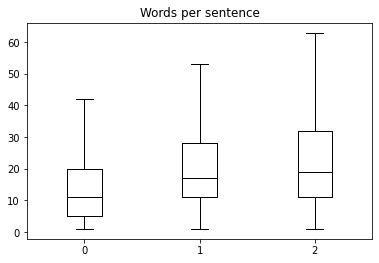

In [ ]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_ckpt = 'albert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
tokenizer.vocab_size

30000

In [ ]:
train_texts = list(train_df['Sentence'])
train_labels = list(train_df['Label'])

In [ ]:
valid_texts = list(valid_df['Sentence'])
valid_labels = list(valid_df['Label'])

## 5) Encoding train-valid

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)

In [ ]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [ ]:
import torch

In [ ]:
# Use in case of CUDA memory error

# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [ ]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
# Defining hyperparameters
eval_batch_size = 16
logging_steps = len(train_texts) // eval_batch_size
model_name = f"{model_ckpt}-finetuned-combined-DS"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=3.2531528713821575e-05,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=16,
                                  weight_decay=0.28844035113697053,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.0,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='info', 
                                  report_to="wandb", 
                                  run_name="albert-combined-DS",
                                  push_to_hub=True)

In [ ]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device('cuda')
    inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.21, 0.33, 0.46]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
# enter your personal write token here

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer, 
                        callbacks = [EarlyStoppingCallback(early_stopping_patience = 2, early_stopping_threshold=0.0001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "n

wandb: Currently logged in as: nn007. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
711,1.072600,1.035480,0.502809,0.396416,0.455114,0.381179
1422,1.036700,1.144877,0.335674,0.462743,0.350393,0.216617
2133,1.069100,1.074897,0.499298,0.459460,0.428226,0.386535
2844,0.984400,0.945766,0.535112,0.538329,0.538310,0.524866
3555,0.931800,0.937163,0.556882,0.574042,0.559555,0.550825
4266,0.931300,0.922061,0.527388,0.577160,0.532628,0.522200
4977,0.869200,0.909913,0.561096,0.576431,0.558532,0.551984
5688,0.853000,0.899907,0.599017,0.608931,0.584008,0.581429
6399,0.795400,0.882135,0.615169,0.617716,0.601678,0.598831
7110,0.801500,0.877714,0.610253,0.615590,0.596382,0.594182


***** Running Evaluation *****
  Num examples = 1424
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to albert-base-v2-finetuned-combined-DS/checkpoint-711
Configuration saved in albert-base-v2-finetuned-combined-DS/checkpoint-711/config.json
Model weights saved in albert-base-v2-finetuned-combined-DS/checkpoint-711/pytorch_model.bin
tokenizer config file saved in albert-base-v2-finetuned-combined-DS/checkpoint-711/tokenizer_config.json
Special tokens file saved in albert-base-v2-finetuned-combined-DS/checkpoint-711/special_tokens_map.json
tokenizer config file saved in albert-base-v2-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in albert-base-v2-finetuned-combined-DS/specia

eval/accuracy,▅▁▅▆▇▆▇███
eval/f1,▄▁▄▇▇▇▇███
eval/loss,▅█▆▃▃▂▂▂▁▁
eval/precision,▁▃▃▅▇▇▇███
eval/recall,▄▁▃▆▇▆▇███
eval/runtime,▃▁▂▃▃▄▁▃██
eval/samples_per_second,▆█▇▆▆▅▇▆▁▁
eval/steps_per_second,▆█▇▆▇▅█▆▁▁
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▆▆▅▄▃▃▂▁


In [ ]:
trainer.push_to_hub()

Saving model checkpoint to albert-base-v2-finetuned-combined-DS
Configuration saved in albert-base-v2-finetuned-combined-DS/config.json
Model weights saved in albert-base-v2-finetuned-combined-DS/pytorch_model.bin
tokenizer config file saved in albert-base-v2-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in albert-base-v2-finetuned-combined-DS/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/44.6M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/nn007/albert-base-v2-finetuned-combined-DS
   0d73aaa..2c6cebd  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/nn007/albert-base-v2-finetuned-combined-DS
   0d73aaa..2c6cebd  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.610252808988764}, {'name': 'Precision', 'type': 'precision', 'value': 0.6155902032833049}, {'name': 'Recall', 'type': 'recall', 'value': 0.5963817898950604}, {'name': 'F1', 'type': 'f1', 'value': 0.5941818607760688}]}
To https://huggingface.co/nn007/albert-base-v2-finetuned-combined-DS
   2c6cebd..11e00bd  main -> main

   2c6cebd..11e00bd  main -> main



'https://huggingface.co/nn007/albert-base-v2-finetuned-combined-DS/commit/2c6cebdfc52c55bbb0d7fdb604eb9908e43070d8'

## 8) Predictions and Results

In [ ]:
test_texts = list(test_df['Sentence'])
test_labels = list(test_df['Label'])

In [ ]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [ ]:
preds_output_test = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1424
  Batch size = 16


In [ ]:
preds_output_test.metrics

{'test_loss': 0.8585286736488342,
 'test_accuracy': 0.6109550561797753,
 'test_precision': 0.6195871057909517,
 'test_recall': 0.6045271945271903,
 'test_f1': 0.601781091800007,
 'test_runtime': 48.5206,
 'test_samples_per_second': 29.348,
 'test_steps_per_second': 1.834}

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [ ]:
y_valid_test = np.array(test_dataset.labels)

In [ ]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [ ]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.85      0.62      0.71       643
         CAG       0.47      0.64      0.54       461
         OAG       0.54      0.56      0.55       320

    accuracy                           0.61      1424
   macro avg       0.62      0.60      0.60      1424
weighted avg       0.66      0.61      0.62      1424



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

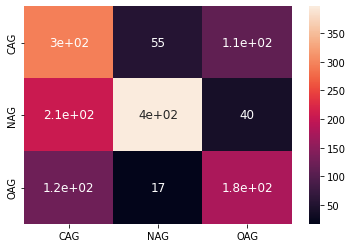

In [ ]:
cm_labels = np.unique(y_valid_trying)
cm_array = confusion_matrix(y_valid_trying, y_preds_trying)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 